In [11]:
import glob 
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal, Laplace
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
from tensorboardX import SummaryWriter

import umap

import poisevae
from poisevae.datasets import MNIST_SVHN
from poisevae.networks.MNISTSVHNNetworks import EncMNIST, DecMNIST, EncSVHN, DecSVHN

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = False

In [2]:
HOME_PATH = os.path.expanduser('~')

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
MNIST_PATH = os.path.join(HOME_PATH, 'Datasets/MNIST/%s.pt')
SVHN_PATH = os.path.join(HOME_PATH, 'Datasets/SVHN/%s_32x32.mat')
MNIST_SAMPLER_PATH = os.path.join(HOME_PATH, 'Datasets/MNIST/MNIST_%s_idx.pt')
SVHN_SAMPLER_PATH = os.path.join(HOME_PATH, 'Datasets/SVHN/SVHN_%s_idx.pt')

joint_dataset_train = MNIST_SVHN(mnist_pt_path=MNIST_PATH % 'train', svhn_mat_path=SVHN_PATH % 'train')
joint_dataset_test = MNIST_SVHN(mnist_pt_path=MNIST_PATH % 'test', svhn_mat_path=SVHN_PATH % 'test')

# joint_dataset_train = MNIST_SVHN(mnist_pt_path=MNIST_PATH % 'train', svhn_mat_path=SVHN_PATH % 'train', 
#                                 sampler_mnist=torch.load(MNIST_SAMPLER_PATH % 'train'), 
#                                 sampler_svhn=torch.load(SVHN_SAMPLER_PATH % 'train'))
# joint_dataset_test = MNIST_SVHN(mnist_pt_path=MNIST_PATH % 'test', svhn_mat_path=SVHN_PATH % 'test',
#                                sampler_mnist=torch.load(MNIST_SAMPLER_PATH % 'test'), 
#                                sampler_svhn=torch.load(SVHN_SAMPLER_PATH % 'test'))

In [5]:
batch_size = 256
train_loader = torch.utils.data.DataLoader(joint_dataset_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(joint_dataset_test, batch_size=batch_size, shuffle=True, drop_last=True)
len(train_loader), len(test_loader)

(234, 39)

In [6]:
def mask_missing(data):
    # data: (mnist, svhn, label, label)
    rand_num = random.random()
    if rand_num < 0.2: # Send both
        return data
    elif rand_num > 0.6: # Send SVHN only
        return None, *data[1:]
    else: # Send MNIST only
        return data[0], None, *data[2:]

In [7]:
lat1, lat2 = 16, 16
enc_mnist = EncMNIST(lat1).to(device)
dec_mnist = DecMNIST(lat1).to(device)
enc_svhn = EncSVHN(lat2).to(device)
dec_svhn = DecSVHN(lat2).to(device)

vae = poisevae.POISEVAE([enc_mnist, enc_svhn], [dec_mnist, dec_svhn], likelihoods=[Laplace, Laplace],
                        latent_dims=[lat1, (lat2, 1, 1)], batch_size=batch_size, fix_t=True).to(device)
# vae = poisevae.POISEVAE([enc_svhn, enc_mnist], [dec_svhn, dec_mnist], likelihoods=[Laplace, Laplace],
#                         latent_dims=[(lat2, 1, 1), lat1], batch_size=batch_size).to(device)

In [8]:
class SVHN_Classifier(nn.Module):
    def __init__(self):
        super(SVHN_Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 500)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)


class MNIST_Classifier(nn.Module):
    def __init__(self):
        super(MNIST_Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)
    
clfs = [MNIST_Classifier().to(device), SVHN_Classifier().to(device)]
optims = [optim.Adam(clfs[0].parameters(), lr=1e-3), optim.Adam(clfs[1].parameters(), lr=1e-3)]

In [21]:
clfs[0].train()
clfs[1].train()
losses = np.zeros((2, 50))
for k in tqdm(range(50)):
    for data in train_loader:
        data[0] = data[0].reshape(-1, 1, 28, 28)
        assert (data[2] == data[3]).all()
        for i, (clf, optimizer) in enumerate(zip(clfs, optims)):
            optimizer.zero_grad()
            pred = clf(data[i].to(device, torch.float32))

            loss = F.cross_entropy(pred, data[i+2].to(device)) 

            losses[i, k] += loss.item()
            loss.backward()
            optimizer.step()
plt.plot(losses[0])
plt.plot(losses[1])

In [34]:
# Eval
clfs[0].eval()
clfs[1].eval()
correct = np.zeros(2)
with torch.no_grad():
    for data in test_loader:
        data[0] = data[0].reshape(-1, 1, 28, 28)
        assert (data[2] == data[3]).all()
        for i, clf in enumerate(clfs):
            _, pred = clf(data[i].to(device, torch.float32)).max(dim=1)
            correct[i] += (pred == data[i+2].to(device)).sum().item()
correct / len(test_loader.dataset)

array([0.98929893, 0.84678468])

In [28]:
path = '../example/runs/MNIST_SVHN/fix_t/2201251135'
# vae, _, epoch = poisevae.utils.load_checkpoint(vae, load_path=sorted(glob.glob(os.path.join(path, 'train*.pt')))[-1])
vae, _, epoch = poisevae.utils.load_checkpoint(vae, load_path=os.path.join(path, 'training_300.pt'))
epoch

300

In [92]:
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results = vae([data[0].to(device, dtype=torch.float32), data[1].to(device, dtype=torch.float32)], 
                      n_gibbs_iter=30)
        break

In [93]:
x_rec = results['x_rec']
if isinstance(x_rec[0], torch.distributions.Distribution):
    x_rec = [x_rec[0].loc, x_rec[1].loc]
    
x_rec[1].shape, data[1].shape

(torch.Size([256, 3, 32, 32]), torch.Size([256, 3, 32, 32]))

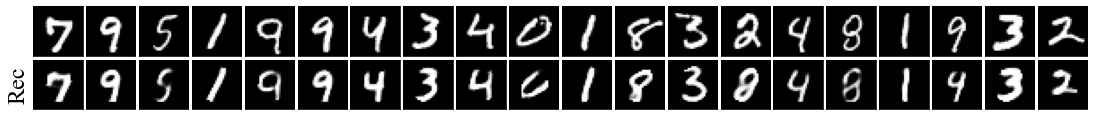

In [94]:
ncols = min(len(x_rec[0]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[0], x_rec[0])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().reshape(28, 28), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'MNISTRec.pdf', dpi=300)

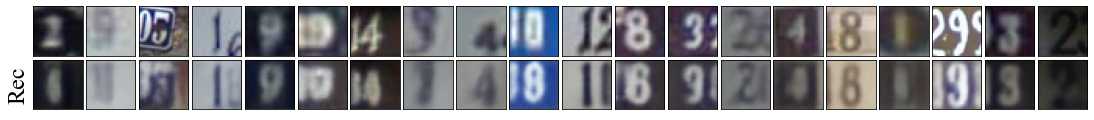

In [95]:
ncols = min(len(x_rec[1]), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(data[1], x_rec[1])):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.cpu().numpy().transpose(1, 2, 0), cmap='gray')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
# fig.savefig(PATH + 'SVHNRec.pdf', dpi=300)

### Cross Generation

#### MNIST -> SVHN

In [35]:
correct = 0
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results = vae([data[0].to(device, dtype=torch.float32), None], n_gibbs_iter=100)
        _, pred = clfs[1](results['x_rec'][1].loc).max(dim=1)
        correct += (pred == data[i+2].to(device)).sum().item()
        break
correct / batch_size #len(test_loader.dataset)

0.11328125

#### MNIST <- SVHN

In [36]:
correct = 0
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results = vae([None, data[1].to(device, dtype=torch.float32)], n_gibbs_iter=100)
        _, pred = clfs[0](results['x_rec'][0].loc.view(-1, 1, 28, 28)).max(dim=1)
        correct += (pred == data[i+2].to(device)).sum().item()
        break
correct / batch_size #len(test_loader.dataset)

0.109375

### Joint Generation

In [37]:
correct = 0
with torch.no_grad():
    for i, data in enumerate(test_loader):
        results = vae.generate(data[0].shape[0], n_gibbs_iter=100)
        _, pred1 = clfs[0](results['x_rec'][0].loc.view(-1, 1, 28, 28)).max(dim=1)
        _, pred2 = clfs[1](results['x_rec'][1].loc).max(dim=1)
        correct += (pred1 == pred2).sum().item()
        break
correct / batch_size #len(test_loader.dataset)

0.08203125